In [9]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
sns.set()

### Using term frequency of n-grams across Daily Mail articles which belong to money/markets section

In [10]:
client = bigquery.Client()

query=f"""
-- return 17125 rows
select a.GKGRECORDID, b.DATE, a.content from
(select GKGRECORDID, content from goldenfleece.final_task.daily_mail_2015 
where content is not null) a
left join
-- remove duplicate GKGRECORDID: 20160118230000-260 and 20160725233000-684
(select distinct GKGRECORDID, DATE from goldenfleece.final_task.gkg_daily_mail_v2
) b
on a.GKGRECORDID = b.GKGRECORDID
order by a.GKGRECORDID;
"""
document_df = client.query(query).to_dataframe()
document_df.head(3)

,GKGRECORDID,DATE,content
0,20150301010000-1303,2015-03-01,"Newspaper publisher Trinity Mirror will reveal a fall in profits tomorrow. The Daily Mirror owner is expected to report profits of £100million for last year, down slightly on the previous year, according to investment bank Numis. Investors will also be looking for further guidance on the sums expected to be paid out after phone-hacking claims against the publisher. The company admitted for the first time in September that some of its journalists were involved. Under chief executive Simon Fox, Trinity Mirror said last month it would increase the provisional sum set aside to deal with phone-hacking claims by £8million to £12million. There was also uncertainty over whether or not new allegations would emerge. Trinity has said that it has received a £12million special dividend from Local World, the regional newspaper group in which it has a stake. (The Mail On Sunday publisher DMGT also has a stake.) This is in addition to the £3million it received during 2014, so its initial investment of £14.2million for a 20 per cent stake is more than covered. The publisher has reduced debt to below £20million, while paying £17million of advanced contributions to the pension scheme."
1,20150301010000-1308,2015-03-01,"The FTSE 100 soared to a record high last week, but private share buyers believe politicians need to do more to encourage stock market investment, and most believe politicians do not do enough to support them. The blue-chip index of top London stock ended last week at 6945 – finally surpassing the peak hit during the dotcom boom at the end of 1999. Although a boon to many private share investors, a survey by The Share Centre, a leading stock broker, found the majority of people still felt that they were undervalued by government. The survey of 1,000 investors found that almost three-quarters did not believe any political party was sympathetic to their needs and more than half said they would be swayed to vote for a party that addressed their interests. The biggest single issue was the complexity of the tax system – 68 per cent said they would like taxation to be made simpler. Almost as many (61 per cent) said they would like tax on pension schemes to be reduced – a potential blow to Ed Miliband after his announcement last week that he would increase taxes on large pension pots to pay for a cut in university tuition fees. But Richard Stone, chief executive of The Share Centre, said the survey showed that investors were concerned that an inconclusive election result would create market turmoil. ‘We asked people what they thought the most likely outcome would be and 34 per cent said they expected another coalition and 28 per cent said they expected a minority government. That tells me they are bracing themselves for more volatility in the market.’ The survey also found that investors wanted to see cuts to the stamp duty on shares, a reduction in inheritance tax and a cut to capital gains tax."
2,20150301010000-1311,2015-03-01,"The broadcaster ITV, which is in talks to buy the production company behind BBC1’s hit show The Voice, will report sharply increased profits this week as boss Adam Crozier’s five-year turnaround plan comes to fruition. ITV is expected to report profits of £648million for 2014, a 22 per cent rise on 2013, said investment bank Credit Suisse. Crozier and chairman Archie Norman took over in 2010 and set out a five-year plan to complete their turnaround strategy. The broadcaster has reduced its dependence on advertising by buying production companies in Europe and the US. Now just 55 per cent of its revenue comes from advertising, compared with more than 75 per cent in 2010. ITV said on Friday it was in exclusive talks to buy Talpa, the production company owned by Dutch reality TV pioneer John de Mol, who created Big Brother. In 2014, ITV’s main television channels, which have shown popular series such as Mr Selfridge and Downton Abbey, are set to have seen

In [11]:
document_df = document_df.astype({"DATE":"datetime64"}) 
document_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   GKGRECORDID  17125 non-null  object        
 1   DATE         17125 non-null  datetime64[ns]
 2   content      17125 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 85.6 MB


### Convert the corpus into time series

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
import re
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer, LancasterStemmer

def preprocess_text(text):
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    return text

class CustomVectorizer(CountVectorizer):
    def build_tokenizer(self):
        tokenize = super().build_tokenizer()
#         wnl = WordNetLemmatizer()
#         return lambda doc: [wnl.lemmatize(t) for t in tokenize(doc)]
        porter = PorterStemmer()
        return lambda doc: [porter.stem(t) for t in tokenize(doc)]


vectorizer = CustomVectorizer(preprocessor=preprocess_text, stop_words="english", min_df=0.02)

# experiment model with target leakage
tf_sparse = vectorizer.fit_transform(document_df["content"])

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

In [14]:
tf_sparse

<17125x1536 sparse matrix of type '<class 'numpy.int64'>'
	with 2106896 stored elements in Compressed Sparse Row format>

In [7]:
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer, LancasterStemmer

wnl = WordNetLemmatizer()
output = [wnl.lemmatize(t, pos="v") for t in ["achieve", "achieved"]]

porter = PorterStemmer()
output = [porter.stem(t) for t in ["achieve", "achieved"]]

In [15]:
vectorizer.get_feature_names()[:10]

['abandon',
 'abil',
 'abl',
 'abov',
 'abroad',
 'acceler',
 'accept',
 'access',
 'accord',
 'account']

In [16]:
# to inspect how well the default analyzer in CountVectorizer performs
analyze = vectorizer.build_analyzer()

# original document
print(document_df["content"].loc[1])

# first 20 tokenized terms
analyze(document_df["content"].loc[1])[:20]

The FTSE 100 soared to a record high last week, but private share buyers believe politicians need to do more to encourage stock market investment, and most believe politicians do not do enough to support them. The blue-chip index of top London stock ended last week at 6945 – finally surpassing the peak hit during the dotcom boom at the end of 1999. Although a boon to many private share investors, a survey by The Share Centre, a leading stock broker, found the majority of people still felt that they were undervalued by government. The survey of 1,000 investors found that almost three-quarters did not believe any political party was sympathetic to their needs and more than half said they would be swayed to vote for a party that addressed their interests. The biggest single issue was the complexity of the tax system – 68 per cent said they would like taxation to be made simpler. Almost as many (61 per cent) said they would like tax on pension schemes to be reduced – a potential blow to Ed

['ftse',
 'soar',
 'record',
 'high',
 'week',
 'privat',
 'share',
 'buyer',
 'believ',
 'politician',
 'need',
 'encourag',
 'stock',
 'market',
 'invest',
 'believ',
 'politician',
 'support',
 'blue',
 'chip']

In [17]:
# tf_df = pd.DataFrame.sparse.from_spmatrix(tf_sparse)
tf_df = pd.DataFrame(tf_sparse.toarray(), columns=vectorizer.get_feature_names())

In [18]:
tf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Columns: 1536 entries, abandon to zero
dtypes: int64(1536)
memory usage: 200.7 MB


In [19]:
# add the date back to term frequency matrix to aggregate by month
tf_df["DATE"] = document_df["DATE"]

In [20]:
tf_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Columns: 1537 entries, abandon to DATE
dtypes: datetime64[ns](1), int64(1536)
memory usage: 200.8 MB


In [21]:
monthly_tf_df = tf_df.set_index("DATE").resample("MS").mean()

In [22]:
monthly_tf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2015-03-01 to 2020-09-01
Freq: MS
Columns: 1536 entries, abandon to zero
dtypes: float64(1536)
memory usage: 804.5 KB


In [23]:
query=f"""
SELECT DATE, GDP from
goldenfleece.final_task.monthly_gdp_lag 
where DATE >= '2015-02-01'
order by DATE
"""
gdp_df = client.query(query).to_dataframe()
gdp_df.head()

,DATE,GDP
0,2015-02-01,0.4
1,2015-03-01,0.4
2,2015-04-01,0.6
3,2015-05-01,0.7
4,2015-06-01,0.7


In [24]:
gdp_df = gdp_df.astype({"DATE":"datetime64"}).set_index("DATE")
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2015-02-01 to 2020-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [25]:
# reset index to set DATE as column
combined_df = monthly_tf_df.merge(gdp_df, left_index=True, right_index=True, how="right").reset_index()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 1538 entries, DATE to GDP
dtypes: datetime64[ns](1), float64(1537)
memory usage: 817.2 KB


In [26]:
from cross_validate import cross_validate, build_design_matrix, evaluate_features

### Check stationarity assumption

From visual inspection, exclude COVID period to satisfy stationarity assumption

In [31]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

# estimator=LinearRegression()
# estimator=Ridge()
estimator=DecisionTreeRegressor(random_state=0)

rmse_list = []
design_df_list = []
result_df_list = []
for horizon in [1,2,3,4,5,6]:
    design_df, result_df = evaluate_features(
        combined_df,
        date_col="DATE",
        var_col="GDP",
        horizon=horizon,
        estimator=estimator,
        initial=36,
        period=1,
        return_model=True,
        start_date="2015-03-01",
        end_date="2020-03-01",
    )
    rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
    rmse_list.append(rmse)
    design_df_list.append(design_df)
    result_df_list.append(result_df)
    print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}")

Average RMSE over 22 predictions for 1-month horizon: 0.709
Average RMSE over 20 predictions for 2-month horizon: 0.688
Average RMSE over 18 predictions for 3-month horizon: 0.628
Average RMSE over 16 predictions for 4-month horizon: 0.832
Average RMSE over 14 predictions for 5-month horizon: 0.851
Average RMSE over 12 predictions for 6-month horizon: 0.946

Average RMSE across different horizons: 0.776


<AxesSubplot:xlabel='date'>

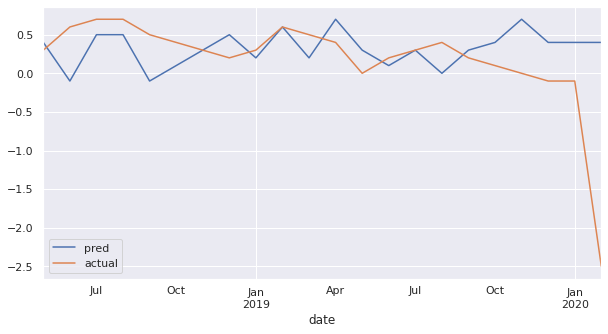

In [32]:
# check 1-month horizon plot
result_df = result_df_list[0]
result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5))